# BPC with ANS

This notebook covers evaluation of Bayesian Predicitve Coding with closed form formulas, paired with Asymmetric Numeral Systems using the compression-evaluation package.

The Predictive Coder and Decoder evaluated in this notebook follows the following structure where the predictor provides Mamaximum A Posteriori (MAP) estimate,

![Encoder](images/PC_processing-Encoder-Point-Predictor.drawio.png)


![Decoder](images/PC_processing-Decoder-Point-Predictor.drawio.png)

Before executing the code below, following pre-requisites (in addition to the ones required for the evaluator package) are required.

In [41]:
%pip install pandas matplotlib numpy scikit-learn
%pip install ../dist/compression_evaluation-0.1.0-py3-none-any.whl --force-reinstall

Note: you may need to restart the kernel to use updated packages.


Processing c:\users\atlee\pycharmprojects\compression-eval\dist\compression_evaluation-0.1.0-py3-none-any.whl
  Using cached matplotlib-3.10.7-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached memory_profiler-0.61.0-py3-none-any.whl.metadata (20 kB)
  Using cached numpy-2.3.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached scipy-1.16.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp312-cp312-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pillow-11.3.0-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached psutil-7.

error: uninstall-no-record-file

× Cannot uninstall matplotlib 3.10.7
╰─> The package's contents are unknown: no RECORD file was found for matplotlib.

hint: You might be able to recover from this via: pip install --force-reinstall --no-deps matplotlib==3.10.7


## Import datasets

Three datasets were used in this evaluation, all extracted from the Ariviyal Nagar weather station. Datasets accessible [here](https://www.ariviyalnagarweatherstation.org/Data.html).

From the dataset, three columns were used for this evaluation, which were extracted and isolated into seperate files for convenience. They were,
1. Solar Radition - A dataseries with a multi-modal (bimodal) distribution
2. Water Content - A dataseries with sudden rises and falls with mostly gradual fade
3. Air Temperature - A dataseries with mostly deterministic patterns with slight noise

In [42]:
import pandas as pd

water_content_df = pd.read_csv(r'..\datasets\AriviyalN_Data_Water_Content.csv')
solar_radiation_df = pd.read_csv(r'..\datasets\AriviyalN_Data_Solar_Radiation.csv')
air_temperature_df = pd.read_csv(r'..\datasets\AriviyalN_Data_Air_Temperature.csv')

extract dataseries,

In [43]:
water_content_column = water_content_df['Water Content']
solar_radiation_column = solar_radiation_df['Solar Radiation']
air_temperature_column = air_temperature_df['Air Temperature']

## Inspect datasets

Basic data pre-processing

In [44]:
def print_invalids_count():
    print("Water Content NaNs:", water_content_column.isna().sum())
    print("Solar Radiation NaNs:", solar_radiation_column.isna().sum())
    print("Air Temperature NaNs:", air_temperature_column.isna().sum())

    print("Water Content Nulls:", water_content_column.isnull().sum())
    print("Solar Radiation Nulls:", solar_radiation_column.isnull().sum())
    print("Air Temperature Nulls:", air_temperature_column.isnull().sum())

def fill_with_mean(series):
    # Find indices where value is NaN or null
    nan_indices = series[series.isna() | series.isnull()].index
    for idx in nan_indices:
        prev_idx = idx - 1
        next_idx = idx + 1
        # Find previous non-null value
        while prev_idx >= 0 and (pd.isna(series.iloc[prev_idx]) or pd.isnull(series.iloc[prev_idx])):
            prev_idx -= 1
        # Find next non-null value
        while next_idx < len(series) and (pd.isna(series.iloc[next_idx]) or pd.isnull(series.iloc[next_idx])):
            next_idx += 1
        # If both indices are valid, fill with their mean
        if prev_idx >= 0 and next_idx < len(series):
            mean_val = (series.iloc[prev_idx] + series.iloc[next_idx]) / 2
            series.iloc[idx] = mean_val
    return series

# Before filling
print("Before cleanup: ")
print_invalids_count()

water_content_column = fill_with_mean(water_content_column)
solar_radiation_column = fill_with_mean(solar_radiation_column)
air_temperature_column = fill_with_mean(air_temperature_column)

# After filling
print("\nAfter cleanup: ")
print_invalids_count()

Before cleanup: 
Water Content NaNs: 1
Solar Radiation NaNs: 1
Air Temperature NaNs: 1
Water Content Nulls: 1
Solar Radiation Nulls: 1
Air Temperature Nulls: 1

After cleanup: 
Water Content NaNs: 0
Solar Radiation NaNs: 0
Air Temperature NaNs: 0
Water Content Nulls: 0
Solar Radiation Nulls: 0
Air Temperature Nulls: 0


C:\Users\atlee\AppData\Local\Temp\ipykernel_16328\994254384.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.iloc[idx] = mean_val
C:\Users\atlee\AppData\Local\Temp\ipykernel_16328\994254384.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.iloc[idx] = mean_val
C:\Users\atlee\AppData\Local\Temp\ipykernel_16328\994254384.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.iloc[idx] = mean_val


Plot each dataseries to observe their continuity

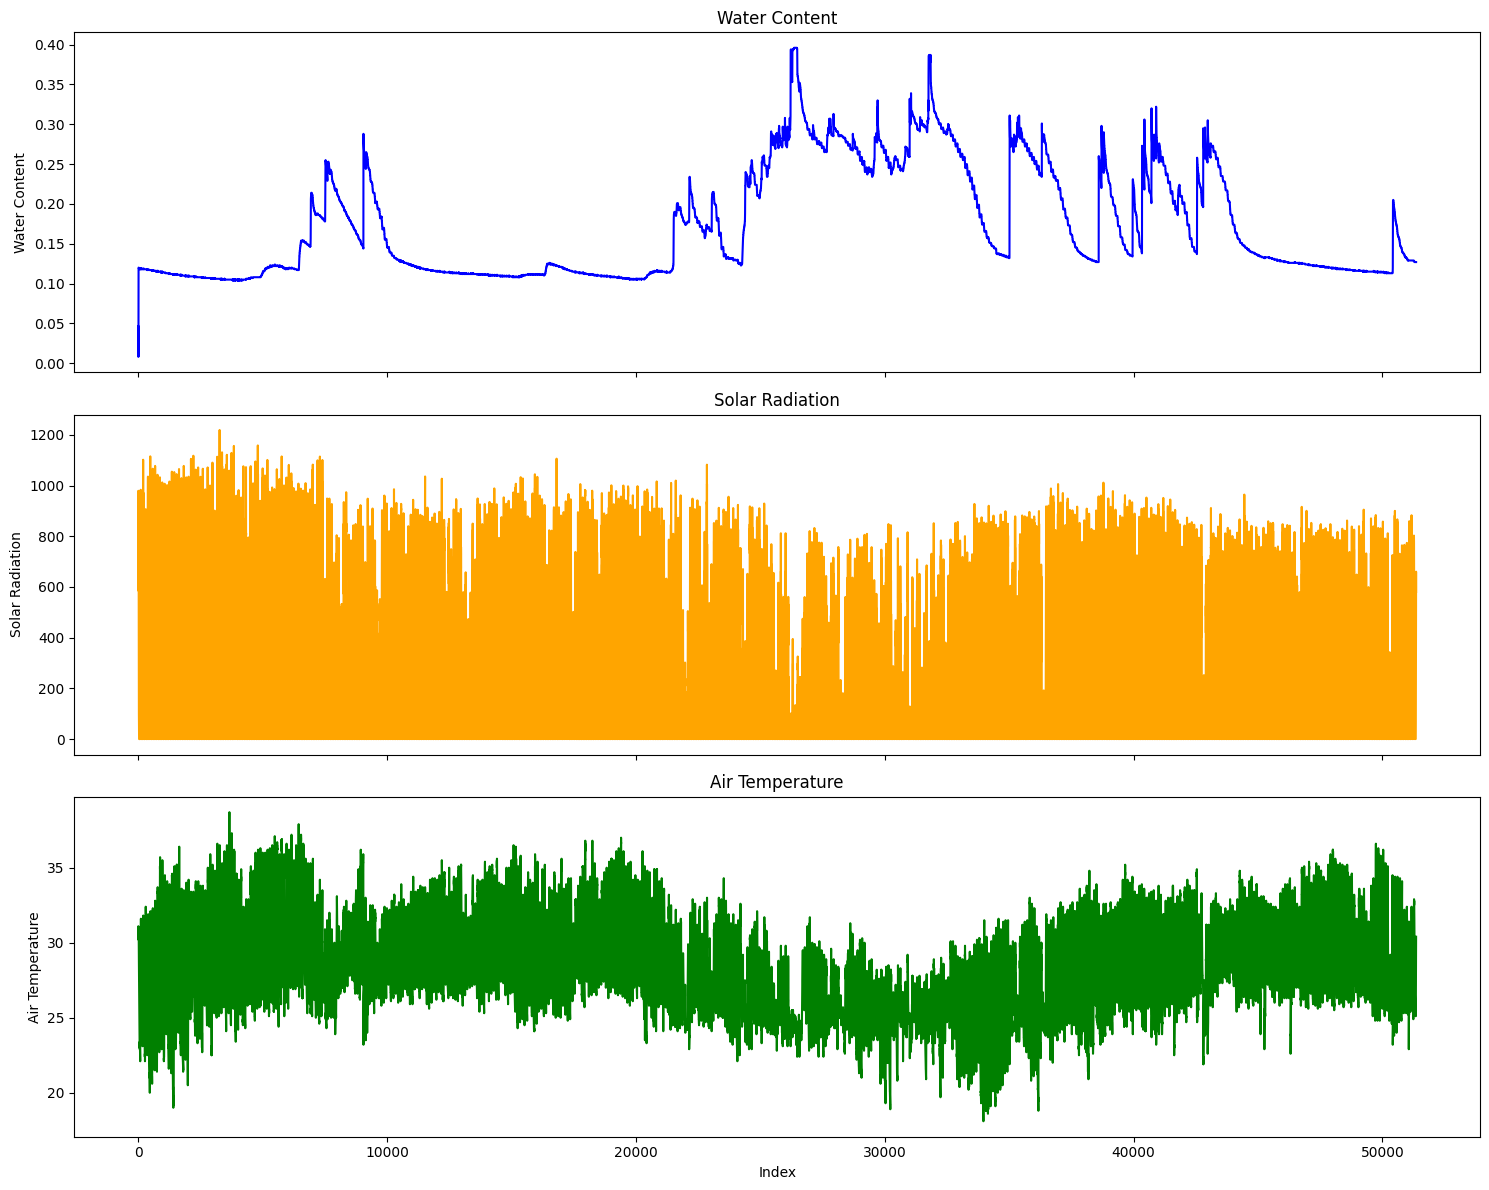

In [45]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

axs[0].plot(water_content_column, color='b')
axs[0].set_title('Water Content')
axs[0].set_ylabel('Water Content')

axs[1].plot(solar_radiation_column, color='orange')
axs[1].set_title('Solar Radiation')
axs[1].set_ylabel('Solar Radiation')

axs[2].plot(air_temperature_column, color='g')
axs[2].set_title('Air Temperature')
axs[2].set_ylabel('Air Temperature')
axs[2].set_xlabel('Index')

plt.tight_layout()
plt.show()

Plot and observe the dataset's value distribution

Completed Calculation of Water Content Histogram...
Completed Calculation of Solar Radiation Histogram...
Completed Calculation of Air Temperature Histogram...


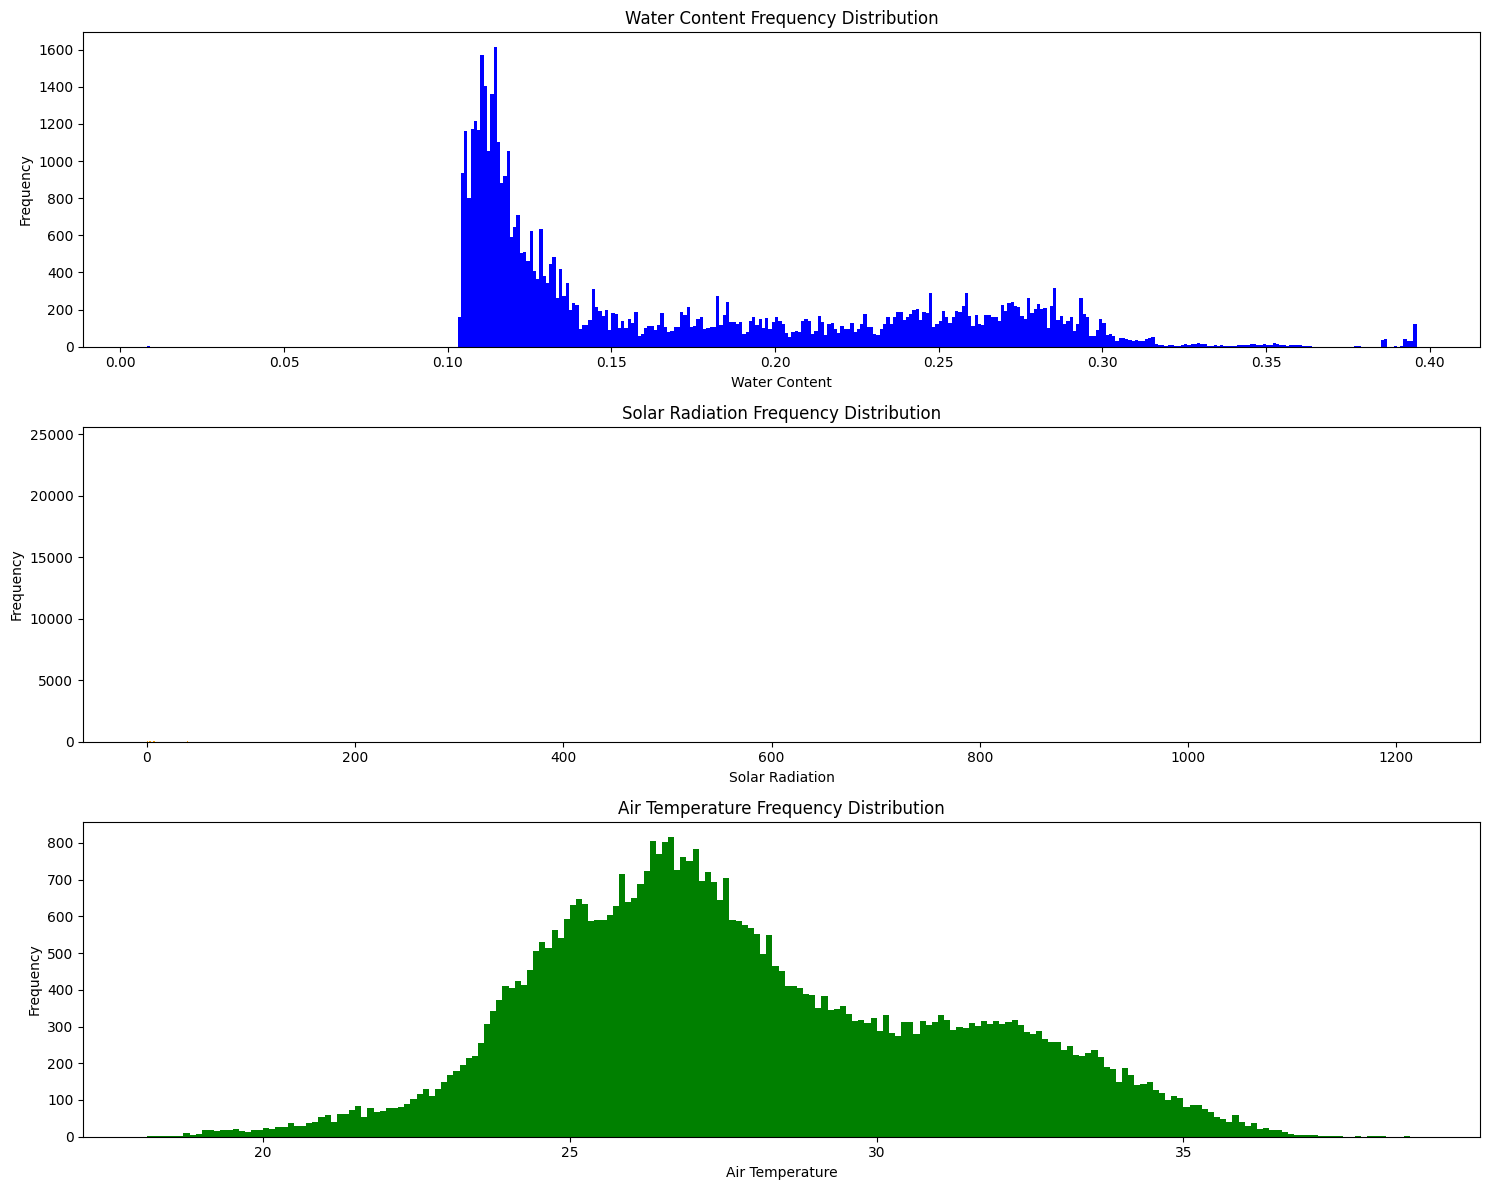

In [46]:
import numpy as np

fig, axs = plt.subplots(3, 1, figsize=(15, 12))

# Bin sizes
water_bin_size = 0.001
solar_bin_size = 0.1
air_bin_size = 0.1

# Water Content
water_min, water_max = water_content_column.min(), water_content_column.max()
water_bins = np.arange(water_min, water_max + water_bin_size, water_bin_size)
axs[0].hist(water_content_column, bins=water_bins, color='b')
axs[0].set_title('Water Content Frequency Distribution')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Water Content')

print("Completed Calculation of Water Content Histogram...")

# Solar Radiation
solar_min, solar_max = solar_radiation_column.min(), solar_radiation_column.max()
solar_bins = np.arange(solar_min, solar_max + solar_bin_size, solar_bin_size)
axs[1].hist(solar_radiation_column, bins=solar_bins, color='orange')
axs[1].set_title('Solar Radiation Frequency Distribution')
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Solar Radiation')

print("Completed Calculation of Solar Radiation Histogram...")

# Air Temperature
air_min, air_max = air_temperature_column.min(), air_temperature_column.max()
air_bins = np.arange(air_min, air_max + air_bin_size, air_bin_size)
axs[2].hist(air_temperature_column, bins=air_bins, color='g')
axs[2].set_title('Air Temperature Frequency Distribution')
axs[2].set_ylabel('Frequency')
axs[2].set_xlabel('Air Temperature')

print("Completed Calculation of Air Temperature Histogram...")

plt.tight_layout()
plt.show()


Plot distribution excluding 0s given it has a relatively very high frequency of occurance compared to other values.

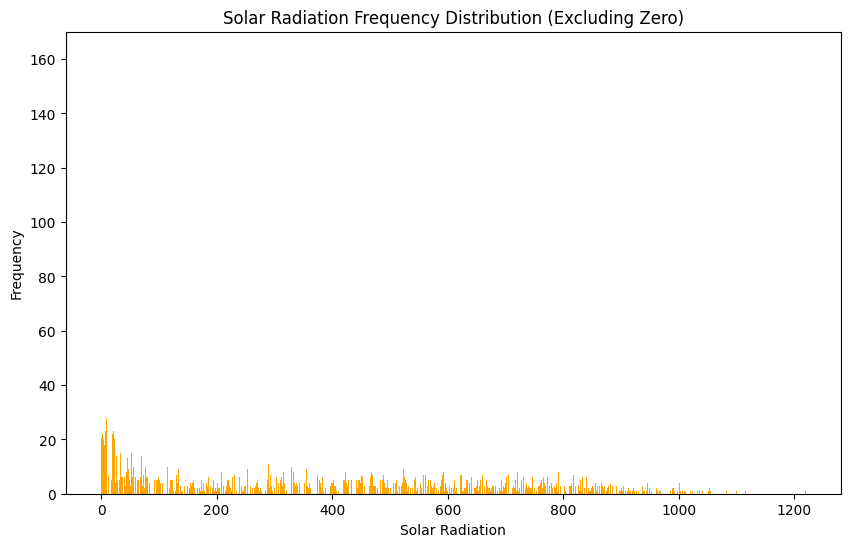

In [47]:
nonzero_solar_radiation = solar_radiation_column[solar_radiation_column != 0]

plt.figure(figsize=(10, 6))
plt.hist(nonzero_solar_radiation, bins=solar_bins, color='orange')
plt.title('Solar Radiation Frequency Distribution (Excluding Zero)')
plt.xlabel('Solar Radiation')
plt.ylabel('Frequency')
plt.show()

Observe the distribution of random windows to help decide on approximate posteriors

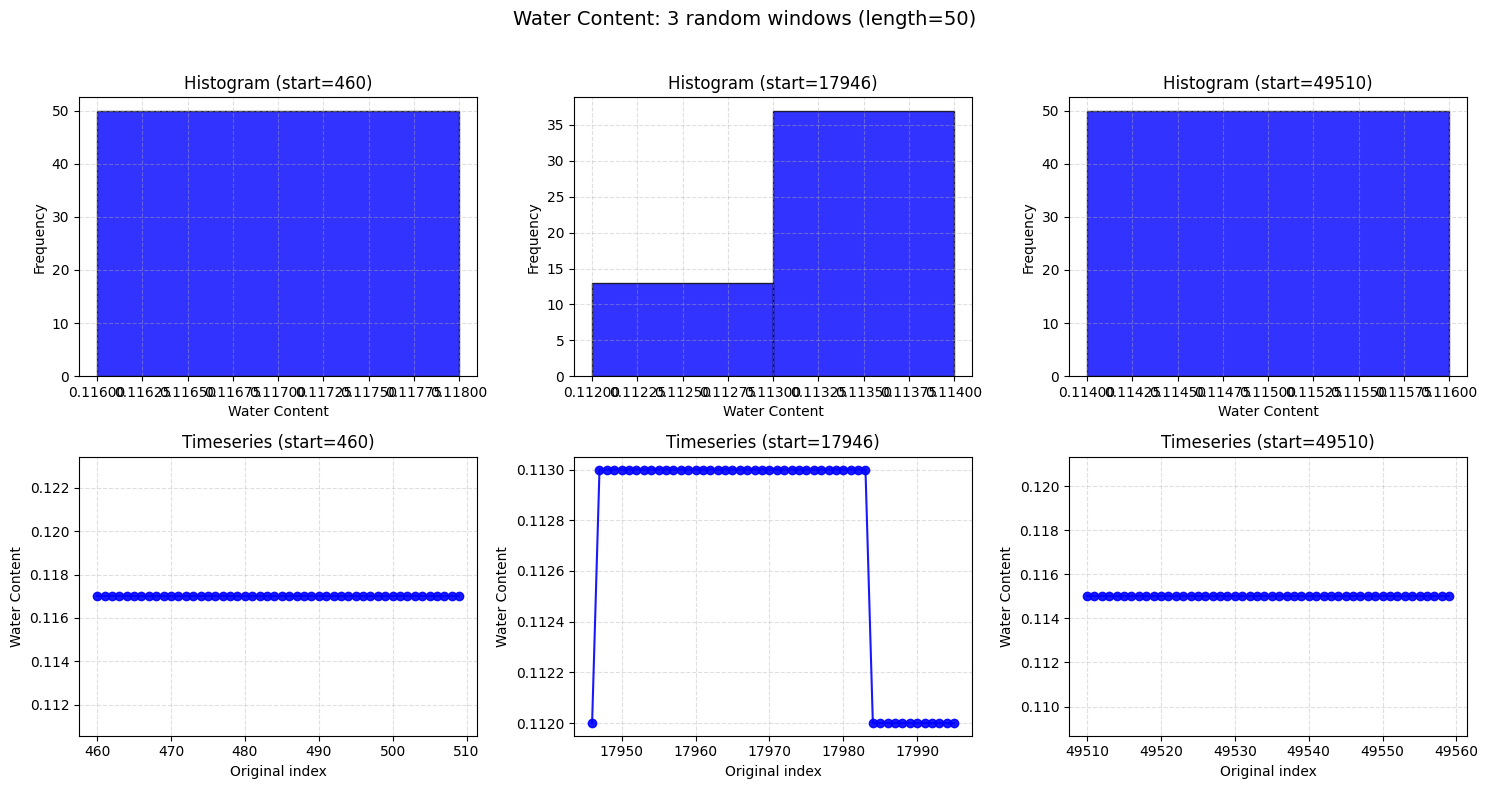

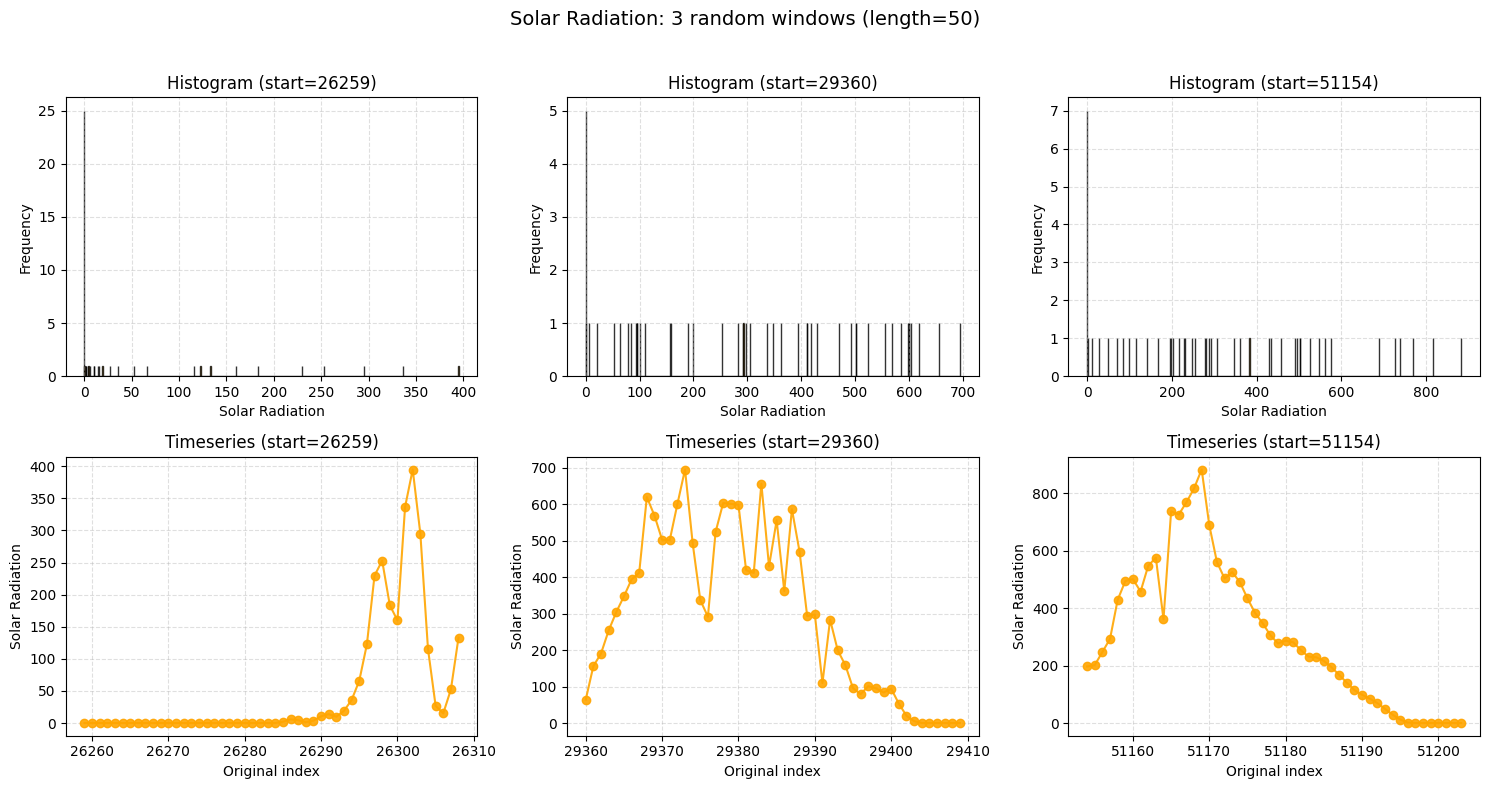

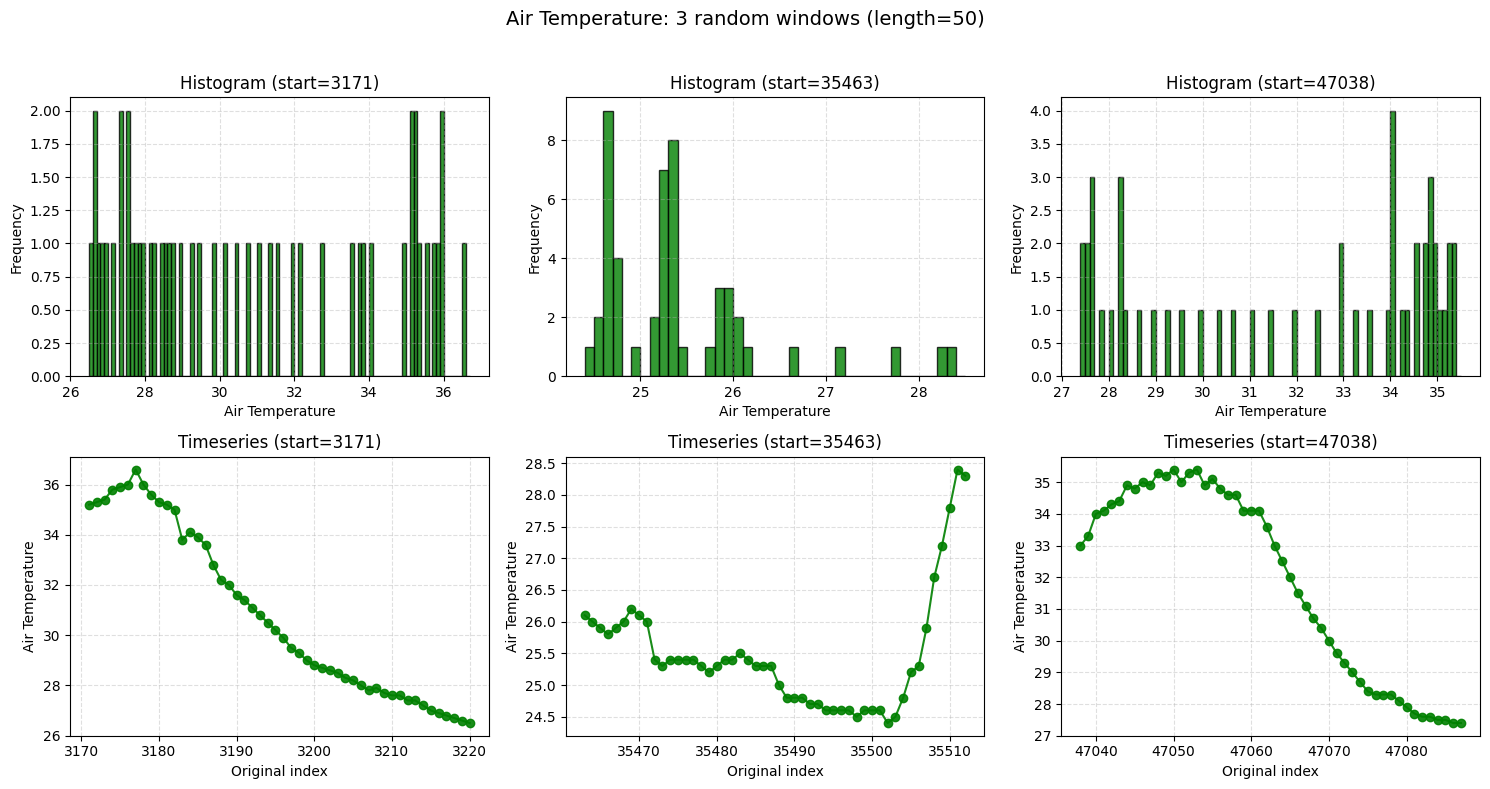

In [48]:
# Group plots by dataseries: for each dataset, show three histograms (one per random window)
# and below them show the corresponding windows as timeseries (points/lines).

window_size = 50
n_windows = 3
rng = np.random.RandomState(123)

datasets = [
    ("Water Content", water_content_column, water_bin_size, 'b'),
    ("Solar Radiation", solar_radiation_column, solar_bin_size, 'orange'),
    ("Air Temperature", air_temperature_column, air_bin_size, 'g'),
]

# reuse rng and datasets already defined in the notebook
starts_per_dataset = []
for name, series, _, _ in datasets:
    max_start = max(0, len(series) - window_size)
    if max_start + 1 >= n_windows:
        starts = rng.choice(np.arange(0, max_start + 1), size=n_windows, replace=False)
    else:
        starts = rng.randint(0, max_start + 1, size=n_windows)
    starts_per_dataset.append(np.sort(starts))

for j, (name, series, bin_size, color) in enumerate(datasets):
    starts = starts_per_dataset[j]
    fig, axs = plt.subplots(2, n_windows, figsize=(5 * n_windows, 8), constrained_layout=False)
    fig.suptitle(f"{name}: {n_windows} random windows (length={window_size})", fontsize=14)

    for k, start in enumerate(starts):
        window = series.iloc[start:start + window_size]
        wmin, wmax = window.min(), window.max()

        # histogram bins for this window (handle degenerate case)
        if wmin == wmax:
            bins = np.array([wmin - bin_size, wmax + bin_size])
        else:
            bins = np.arange(wmin, wmax + bin_size, bin_size)
            if len(bins) < 2:
                bins = np.array([wmin - bin_size, wmax + bin_size])

        ax_hist = axs[0, k] if n_windows > 1 else axs[0]
        ax_ts = axs[1, k] if n_windows > 1 else axs[1]

        # histogram
        ax_hist.hist(window, bins=bins, color=color, edgecolor='black', alpha=0.8)
        ax_hist.set_title(f"Histogram (start={int(start)})")
        ax_hist.set_xlabel(name)
        ax_hist.set_ylabel("Frequency")
        ax_hist.grid(True, linestyle='--', alpha=0.4)

        # timeseries of the window (use original indices to show position in series)
        ax_ts.plot(window.index, window.values, marker='o', linestyle='-', color=color, alpha=0.9)
        ax_ts.set_title(f"Timeseries (start={int(start)})")
        ax_ts.set_xlabel("Original index")
        ax_ts.set_ylabel(name)
        ax_ts.grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Windows show no clear distribution among random sample windows, thus assumptions to fit distributions to families of conjugate priors are made.

In [49]:
# Split training and testing sets

# Air temperature
air_temperature_training = air_temperature_column[:(len(air_temperature_column) * 9) // 10]
air_temperature_testing = air_temperature_column[(len(air_temperature_column) * 9) // 10:]

# Solar radiation
solar_radiation_training = solar_radiation_column[:(len(air_temperature_column) * 9) // 10]
solar_radiation_testing = solar_radiation_column[(len(air_temperature_column) * 9) // 10:]

# Water quality
water_quality_training = water_content_column[:(len(air_temperature_column) * 9) // 10]
water_quality_testing = water_content_column[(len(air_temperature_column) * 9) // 10:]

## Fit parametric distributions to prior

Given no clear observed distributions among sampled windows of values, instead the prior is fit with a distribution closely reflecting past data's true behaviour, and a matching sample distribution is chosen for generating assumptions about the posterior distribution.

In [50]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from compression_evaluation.distributions import Gaussian as CE_Norm
from compression_evaluation.methods import compute_posterior_mixture, plot_mixture_over_hist, approximate_mixture_map_pdf

### For air temperature dataseries

In [51]:
# split training dataeet into training and validating datasets
air_temperature_validating = air_temperature_training[(len(air_temperature_column) * 7) // 9:]
air_temperature_training = air_temperature_training[:(len(air_temperature_column) * 7) // 9]

Air training range: 18.1 to 38.7
Number of bins: 205
First 10 bin centers: [18.150000000000002, 18.250000000000004, 18.350000000000005, 18.450000000000006, 18.550000000000008, 18.65000000000001, 18.75000000000001, 18.850000000000012, 18.950000000000014, 19.050000000000015]
First 10 counts: [2, 1, 2, 1, 3, 2, 10, 6, 8, 17]


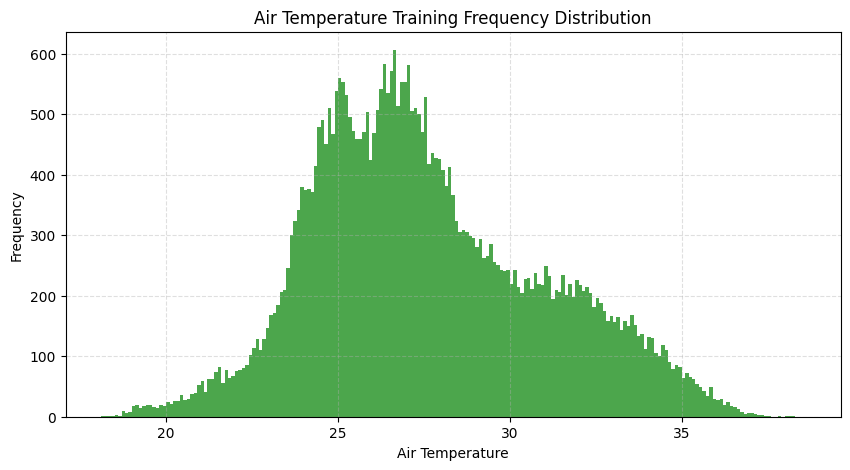

In [52]:
# generate bins and frequency counts for air_temperature_training using air_bin_size
air_train_min = air_temperature_training.min()
air_train_max = air_temperature_training.max()

# handle degenerate case where all values are equal
air_train_bins = np.arange(air_train_min, air_train_max, air_bin_size)
air_train_counts, air_train_bin_edges = np.histogram(air_temperature_training, bins=air_train_bins)
air_train_bin_centers = (air_train_bin_edges[:-1] + air_train_bin_edges[1:]) / 2

# expose results for later cells
print("Air training range:", air_train_min, "to", air_train_max)
print("Number of bins:", len(air_train_bin_centers))
print("First 10 bin centers:", air_train_bin_centers[:10].tolist())
print("First 10 counts:", air_train_counts[:10].tolist())

# plot histogram of training data using the computed bins
plt.figure(figsize=(10, 5))
plt.bar(air_train_bin_centers, air_train_counts, width=air_bin_size, color='g', alpha=0.7)
plt.title('Air Temperature Training Frequency Distribution')
plt.xlabel('Air Temperature')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

From the frequency plot it can be observed that this distribution can be fitted well with two gaussian distributions. Thus they are fit to identify the multi modal 

Mixture weights: [0.68755514 0.31244486]
Means: [25.91658988 31.42944413]
Standard deviations: [2.11091711 2.32947995]


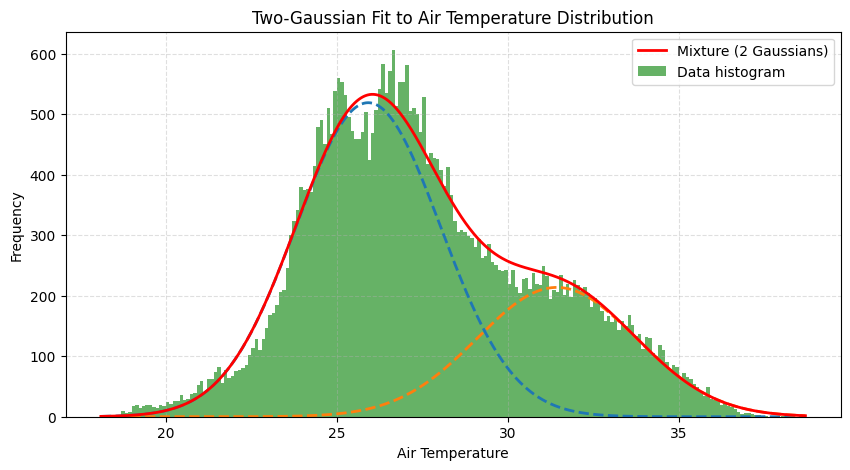

In [53]:
X = np.array(air_temperature_training).reshape(-1, 1)
air_gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
air_gmm.fit(X)

# extract model parameters
air_weights = air_gmm.weights_
air_means = air_gmm.means_.flatten()
air_stds = np.sqrt(air_gmm.covariances_.flatten())

print("Mixture weights:", air_weights)
print("Means:", air_means)
print("Standard deviations:", air_stds)

# plot the histogram
plt.figure(figsize=(10, 5))
plt.bar(air_train_bin_centers, air_train_counts, width=air_bin_size, color='g', alpha=0.6, label='Data histogram')

# overlay the fitted Gaussians
x_vals = np.linspace(air_train_min, air_train_max, 1000)
pdf_total = np.zeros_like(x_vals)

for w, m, s in zip(air_weights, air_means, air_stds):
    pdf = w * norm.pdf(x_vals, m, s) * len(air_temperature_training) * air_bin_size  # scale to histogram counts
    pdf_total += pdf
    plt.plot(x_vals, pdf, '--', linewidth=2)

# total mixture curve
plt.plot(x_vals, pdf_total, 'r-', linewidth=2, label='Mixture (2 Gaussians)')

plt.title('Two-Gaussian Fit to Air Temperature Distribution')
plt.xlabel('Air Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

Create prior as a mixture of models for posteriror generation.

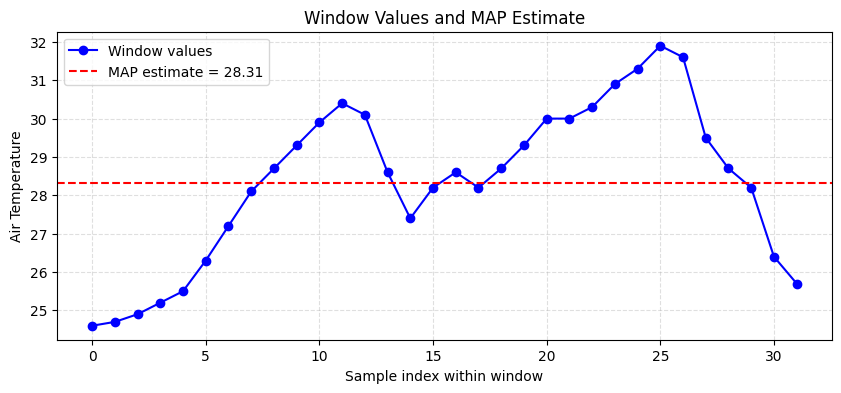

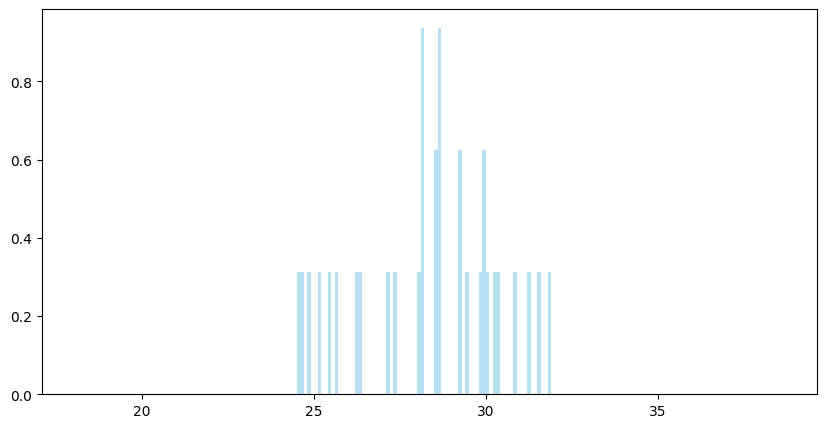

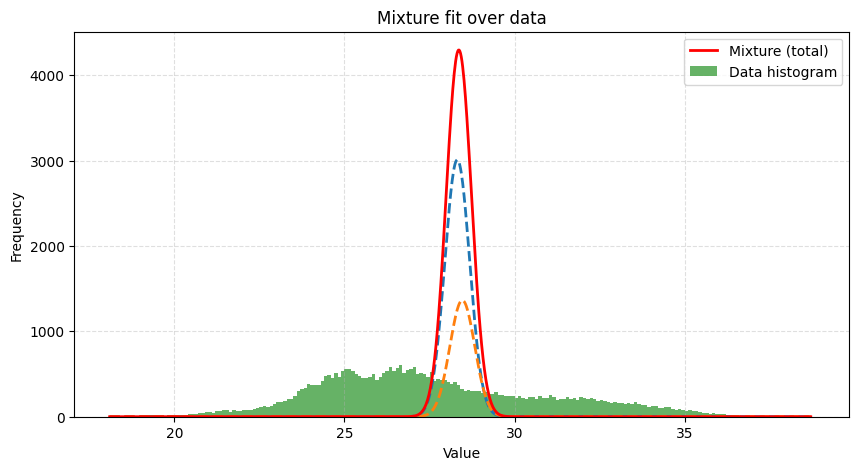

In [54]:
# create mixture prior
air_prior = [
    CE_Norm(air_means[0], air_stds[0] ** 2, air_weights[0]),
    CE_Norm(air_means[1], air_stds[1] ** 2, air_weights[1])
    ]

# extract a random window
air_window_size = 32
start_idx = np.random.randint(0, len(X) - air_window_size + 1)
window = X[start_idx:start_idx + air_window_size]

# compute posterior mixture
air_posterior = compute_posterior_mixture(air_prior, window)
map_estimate = approximate_mixture_map_pdf(air_posterior)

# plot the window with the map estimate at the end
plt.figure(figsize=(10, 4))
plt.plot(window, marker='o', linestyle='-', color='blue', label='Window values')
plt.axhline(map_estimate, color='r', linestyle='--', label=f'MAP estimate = {map_estimate:.2f}')
plt.title('Window Values and MAP Estimate')
plt.xlabel('Sample index within window')
plt.ylabel('Air Temperature')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


# plot distribution of values of the window in the same scale as the prior
plt.figure(figsize=(10, 5))

# histogram of the window
plt.hist(window, bins=np.arange(air_train_min, air_train_max, air_bin_size),
         color='skyblue', alpha=0.6, density=True, label='Window histogram')

# plot distribution with posteriors
plot_mixture_over_hist(X, air_posterior, air_bin_size, air_min, air_max)

The air temperature dataset varies slowly, thus any given window at any point is packed tight compared to the total range of the distribution. Thus the variance in samples is very low compared to the variance of the priors, implying a higher level of confidence among them, therefore the values are naturally centered around the samples.

## Fit Predictor and generate residuals

In [55]:
from compression_evaluation.classes import BpcMapPredictor, UniformQuantizer
from compression_evaluation.methods import build_time_series_dataset
from sklearn.metrics import mean_squared_error

### For air temperature dataset

In [56]:
# fit predictor
air_enveloped_predictor = BpcMapPredictor(air_prior)

BPC MAP predictor MSE (train, 32-dim): 3.0152625233269643
BPC MAP predictor MSE (valid, 32-dim): 2.649838047312002


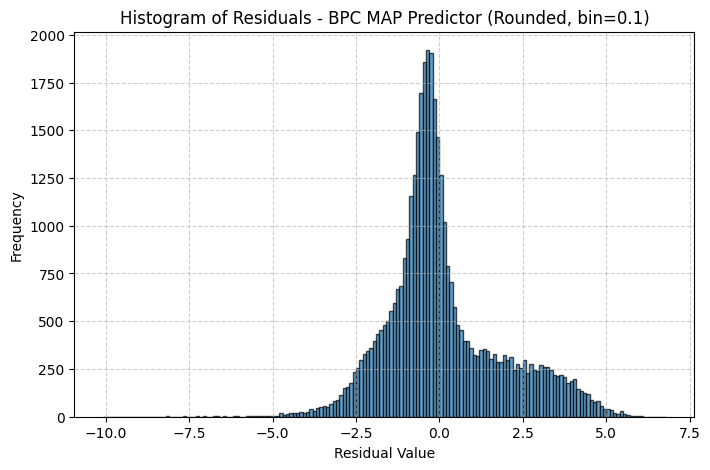

Bin centers: [-10.05  -9.95  -9.85  -9.75  -9.65  -9.55  -9.45  -9.35  -9.25  -9.15
  -9.05  -8.95  -8.85  -8.75  -8.65  -8.55  -8.45  -8.35  -8.25  -8.15
  -8.05  -7.95  -7.85  -7.75  -7.65  -7.55  -7.45  -7.35  -7.25  -7.15
  -7.05  -6.95  -6.85  -6.75  -6.65  -6.55  -6.45  -6.35  -6.25  -6.15
  -6.05  -5.95  -5.85  -5.75  -5.65  -5.55  -5.45  -5.35  -5.25  -5.15
  -5.05  -4.95  -4.85  -4.75  -4.65  -4.55  -4.45  -4.35  -4.25  -4.15
  -4.05  -3.95  -3.85  -3.75  -3.65  -3.55  -3.45  -3.35  -3.25  -3.15
  -3.05  -2.95  -2.85  -2.75  -2.65  -2.55  -2.45  -2.35  -2.25  -2.15
  -2.05  -1.95  -1.85  -1.75  -1.65  -1.55  -1.45  -1.35  -1.25  -1.15
  -1.05  -0.95  -0.85  -0.75  -0.65  -0.55  -0.45  -0.35  -0.25  -0.15
  -0.05   0.05   0.15   0.25   0.35   0.45   0.55   0.65   0.75   0.85
   0.95   1.05   1.15   1.25   1.35   1.45   1.55   1.65   1.75   1.85
   1.95   2.05   2.15   2.25   2.35   2.45   2.55   2.65   2.75   2.85
   2.95   3.05   3.15   3.25   3.35   3.45   3.55   3.65   3.75 

In [57]:
# window dim = 16
X_train_16, y_train_16 = build_time_series_dataset(air_temperature_training, 16, 1)
X_valid_16, y_valid_16 = build_time_series_dataset(air_temperature_validating, 16, 1, False)

# flatten labels to 1D arrays (consistent with LPC example)
y_train_16 = y_train_16.ravel()
y_valid_16 = y_valid_16.ravel()

def predictor_predict_single(envelop, X):
    """Return 1-step predictions for every window in X as 1D array."""
    preds = []
    for win in X:
        p = envelop.predict(1, np.asarray(win))  # should return array shape (1,)
        preds.append(float(np.asarray(p).reshape(-1)[0]))
    return np.array(preds)

y_pred_train_16 = predictor_predict_single(air_enveloped_predictor, X_train_16)
y_pred_valid_16 = predictor_predict_single(air_enveloped_predictor, X_valid_16)

mse_train_16 = mean_squared_error(y_train_16, y_pred_train_16)
mse_valid_16 = mean_squared_error(y_valid_16, y_pred_valid_16)

print("BPC MAP predictor MSE (train, 32-dim):", mse_train_16)
print("BPC MAP predictor MSE (valid, 32-dim):", mse_valid_16)

res_16_train = np.round(y_train_16 - y_pred_train_16, 1)

# build histogram bins (padding like in LPC example)
air_16_bins = np.arange(res_16_train.min() - 5 * air_bin_size,
                        res_16_train.max() + 5 * air_bin_size,
                        air_bin_size)

air_16_counts, air_16_bin_edges = np.histogram(res_16_train, bins=air_16_bins)
air_16_bin_centers = (air_16_bin_edges[:-1] + air_16_bin_edges[1:]) / 2

# plot the residual histogram
plt.figure(figsize=(8, 5))
plt.bar(air_16_bin_centers, air_16_counts, width=air_bin_size, edgecolor='black', alpha=0.7)
plt.title("Histogram of Residuals - BPC MAP Predictor (Rounded, bin={})".format(air_bin_size))
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("Bin centers:", air_16_bin_centers)
print("Frequencies:", air_16_counts)

# pad counts (ANS cannot encode symbols with zero counts)
air_16_padded_counts = air_16_counts + 1

# fit quantizer to residuals
air_16_quantizer = UniformQuantizer(air_bin_size, len(air_16_bins), air_16_bin_edges[0], True)

# map bin centers to symbols
air_16_symbols = [air_16_quantizer.value_to_symbol(val) for val in air_16_bin_centers]
print("Bin symbols (example):", air_16_symbols[:10])
print("Bin count:", len(air_16_symbols))
print("Padded frequencies (len):", len(air_16_padded_counts))

BPC MAP predictor MSE (train, 32-dim): 7.458568499583081
BPC MAP predictor MSE (valid, 32-dim): 6.253456487178934


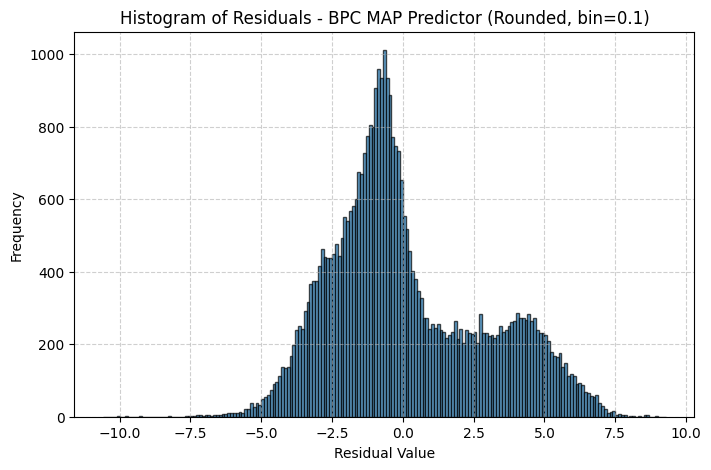

Bin centers: [-10.55 -10.45 -10.35 -10.25 -10.15 -10.05  -9.95  -9.85  -9.75  -9.65
  -9.55  -9.45  -9.35  -9.25  -9.15  -9.05  -8.95  -8.85  -8.75  -8.65
  -8.55  -8.45  -8.35  -8.25  -8.15  -8.05  -7.95  -7.85  -7.75  -7.65
  -7.55  -7.45  -7.35  -7.25  -7.15  -7.05  -6.95  -6.85  -6.75  -6.65
  -6.55  -6.45  -6.35  -6.25  -6.15  -6.05  -5.95  -5.85  -5.75  -5.65
  -5.55  -5.45  -5.35  -5.25  -5.15  -5.05  -4.95  -4.85  -4.75  -4.65
  -4.55  -4.45  -4.35  -4.25  -4.15  -4.05  -3.95  -3.85  -3.75  -3.65
  -3.55  -3.45  -3.35  -3.25  -3.15  -3.05  -2.95  -2.85  -2.75  -2.65
  -2.55  -2.45  -2.35  -2.25  -2.15  -2.05  -1.95  -1.85  -1.75  -1.65
  -1.55  -1.45  -1.35  -1.25  -1.15  -1.05  -0.95  -0.85  -0.75  -0.65
  -0.55  -0.45  -0.35  -0.25  -0.15  -0.05   0.05   0.15   0.25   0.35
   0.45   0.55   0.65   0.75   0.85   0.95   1.05   1.15   1.25   1.35
   1.45   1.55   1.65   1.75   1.85   1.95   2.05   2.15   2.25   2.35
   2.45   2.55   2.65   2.75   2.85   2.95   3.05   3.15   3.25 

In [58]:
# window dim = 32
X_train_32, y_train_32 = build_time_series_dataset(air_temperature_training, 32, 1)
X_valid_32, y_valid_32 = build_time_series_dataset(air_temperature_validating, 32, 1, False)

# flatten labels to 1D arrays (consistent with LPC example)
y_train_32 = y_train_32.ravel()
y_valid_32 = y_valid_32.ravel()

def predictor_predict_single(envelop, X):
    """Return 1-step predictions for every window in X as 1D array."""
    preds = []
    for win in X:
        p = envelop.predict(1, np.asarray(win))  # should return array shape (1,)
        preds.append(float(np.asarray(p).reshape(-1)[0]))
    return np.array(preds)

y_pred_train_32 = predictor_predict_single(air_enveloped_predictor, X_train_32)
y_pred_valid_32 = predictor_predict_single(air_enveloped_predictor, X_valid_32)

mse_train_32 = mean_squared_error(y_train_32, y_pred_train_32)
mse_valid_32 = mean_squared_error(y_valid_32, y_pred_valid_32)

print("BPC MAP predictor MSE (train, 32-dim):", mse_train_32)
print("BPC MAP predictor MSE (valid, 32-dim):", mse_valid_32)

res_32_train = np.round(y_train_32 - y_pred_train_32, 1)

# build histogram bins (padding like in LPC example)
air_32_bins = np.arange(res_32_train.min() - 5 * air_bin_size,
                        res_32_train.max() + 5 * air_bin_size,
                        air_bin_size)

air_32_counts, air_32_bin_edges = np.histogram(res_32_train, bins=air_32_bins)
air_32_bin_centers = (air_32_bin_edges[:-1] + air_32_bin_edges[1:]) / 2

# plot the residual histogram
plt.figure(figsize=(8, 5))
plt.bar(air_32_bin_centers, air_32_counts, width=air_bin_size, edgecolor='black', alpha=0.7)
plt.title("Histogram of Residuals - BPC MAP Predictor (Rounded, bin={})".format(air_bin_size))
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("Bin centers:", air_32_bin_centers)
print("Frequencies:", air_32_counts)

# --- pad counts (ANS cannot encode symbols with zero counts) ---
air_32_padded_counts = air_32_counts + 1

# --- fit quantizer to residuals ---
# Mirror LPC's UniformQuantizer signature:
# UniformQuantizer(bin_size, n_bins, first_edge, centered=True)
air_32_quantizer = UniformQuantizer(air_bin_size, len(air_32_bins), air_32_bin_edges[0], True)

# map bin centers to symbols
air_32_symbols = [air_32_quantizer.value_to_symbol(val) for val in air_32_bin_centers]
print("Bin symbols (example):", air_32_symbols[:10])
print("Bin count:", len(air_32_symbols))
print("Padded frequencies (len):", len(air_32_padded_counts))


# setup ANSCoder


# setup StaticResidualRegressor with BpcMapPredictor


# setup PCEncoder and PCDecoder with created predictor, quantizer and ans coder


## Build frequency table and fit ANS

In [59]:
from compression_evaluation.methods import largest_remainder_quantize
from compression_evaluation.classes import SimpleFrequencyTable, ANSCoder

### For air temperature dataset

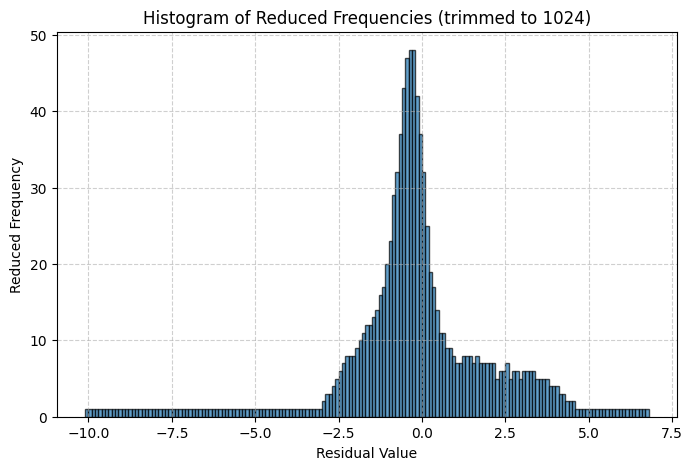

In [61]:
# choose target total (same as LPC example)
target_total = 1024
air_16_counts_trimmed = largest_remainder_quantize(air_16_padded_counts.tolist(), target_total)

# plot reduced counts for sanity
plt.figure(figsize=(8, 5))
plt.bar(air_16_bin_centers, air_16_counts_trimmed, width=air_bin_size, edgecolor='black', alpha=0.7)
plt.title("Histogram of Reduced Frequencies (trimmed to {})".format(target_total))
plt.xlabel("Residual Value")
plt.ylabel("Reduced Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# build frequency table and ans coder
air_16_freq_table = SimpleFrequencyTable(air_16_counts_trimmed)
air_16_ans = ANSCoder(air_16_freq_table, air_16_quantizer)

## Build Predictive Encoder and Decoder

In [62]:
from compression_evaluation.classes import PCEncoder, PCDecoder, StaticResidualRegressor

### For air temperature dataseries

In [63]:
# build predictors for PC
air_16_encoder_residual_regressor = StaticResidualRegressor(air_enveloped_predictor, 16)
air_16_decoder_residual_regressor = StaticResidualRegressor(air_enveloped_predictor, 16)

# initialize sliding windows for encoder/decoder using testing series (first 16 values)
try:
    init_window = air_temperature_testing[0:16].to_numpy()
except Exception:
    # fallback if it's plain numpy or list
    init_window = np.asarray(air_temperature_testing)[0:16]

air_16_encoder_residual_regressor._window = init_window
air_16_decoder_residual_regressor._window = init_window.copy()

# build PC encoder/decoder using predictor, ans, and quantizer
air_16_pc_encoder = PCEncoder(air_16_encoder_residual_regressor, air_16_ans, air_16_quantizer, 1)
air_16_pc_decoder = PCDecoder(air_16_decoder_residual_regressor, air_16_ans, air_16_quantizer, 1)

## Evaluate encoder-decoder pair

In [64]:
from compression_evaluation.evaluator import Evaluator

### For air temperature dataseries

In [66]:
# window dim = 16
# sample test
encoded = air_16_pc_encoder.encode(air_temperature_testing[:50])
decoded = air_16_pc_decoder.decode(encoded)
print("Original series:\t", air_temperature_testing[:50].to_list())
print("Reconstructed series:\t", np.round(np.array(decoded), 1).tolist())

air_16_evaluator = Evaluator(air_16_pc_encoder, air_16_pc_decoder)

# evaluate with test dataset
print("\nEvaluation Metrics:")
air_16_evaluator.evaluate(air_temperature_testing[16:].to_numpy())

Original series:	 [27.5, 27.4, 27.3, 27.3, 27.3, 27.2, 27.1, 27.1, 27.1, 27.0, 26.9, 26.9, 26.9, 26.8, 26.8, 26.7, 26.7, 26.6, 26.6, 26.6, 26.6, 26.6, 26.5, 26.5, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.3, 26.3, 26.3, 26.5, 26.8, 27.0, 27.3, 27.7, 28.1, 28.5, 28.8, 29.3, 29.7, 30.2, 30.9, 31.2, 31.3, 31.9]
Reconstructed series:	 [27.5, 27.4, 27.3, 27.3, 27.3, 27.2, 27.1, 27.1, 27.1, 27.0, 26.9, 26.9, 26.9, 26.8, 26.8, 26.7, 26.7, 26.6, 26.6, 26.6, 26.6, 26.6, 26.5, 26.5, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.3, 26.3, 26.3, 26.5, 26.8, 27.0, 27.3, 27.7, 28.1, 28.5, 28.8, 29.3, 29.7, 30.2, 30.9, 31.2, 31.3, 31.9]

Evaluation Metrics:


{'encode_time_sec': 5.3682182000002285,
 'encode_mem_mb': 613.83984375,
 'decode_time_sec': 2.2305240999999114,
 'decode_mem_mb': 614.03515625,
 'compression_ratio': 10.448979591836734,
 'bits_per_symbol': 6.125,
 'mse': np.float64(0.000835101470921442),
 'snr_db': np.float64(60.06916254842469)}